In [1]:
import warnings, torch, requests, matplotlib.pyplot as plt, networkx as nx
warnings.filterwarnings("ignore")

from transformers import BeitImageProcessor, BeitModel, BertTokenizer, BertModel
from torch_geometric.utils import to_networkx
from PIL import Image

from mmg_builder import build_multimodal_graph

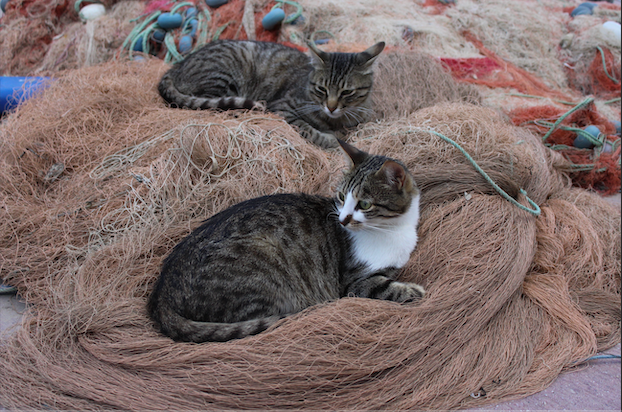

In [2]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")


model_name = "microsoft/beit-base-patch16-224"
beit_processor = BeitImageProcessor.from_pretrained(model_name)
beit = BeitModel.from_pretrained(model_name, use_safetensors=True)


# text = ["BERT is great for natural language processing!"]
text = ["BERT is great for natural language processing!", "Hi my name is Danik.", "Bob"]

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

image

In [3]:
text_inputs = bert_tokenizer(text, return_tensors="pt", padding=True)
print(f'{text_inputs=}')

# Forward pass (no gradient calculation needed for inference)
with torch.no_grad():
    outputs = bert(**text_inputs)

# Extract embeddings
text_embeds = outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_dim]

print(f'{text_embeds.shape=}')

text_inputs={'input_ids': tensor([[  101, 14324,  2003,  2307,  2005,  3019,  2653,  6364,   999,   102],
        [  101,  7632,  2026,  2171,  2003, 19522,  2243,  1012,   102,     0],
        [  101,  3960,   102,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}
text_embeds.shape=torch.Size([3, 10, 768])


In [4]:
img_inputs = beit_processor(images=[image]*3, return_tensors="pt")
print(f'{img_inputs["pixel_values"].shape=}')

with torch.no_grad():
    outputs = beit(**img_inputs, output_hidden_states=True)

# outputs.last_hidden_state → [batch_size, num_patches+1, hidden_dim]
# The first token is [CLS], the rest are patch embeddings
last_hidden = outputs.last_hidden_state

img_embeds = last_hidden[:, 1:, :]  # contextualized patch embeddings
print(f"Patches shape: {img_embeds.shape}")  # (1, num_patches, hidden_dim)


img_inputs["pixel_values"].shape=torch.Size([3, 3, 224, 224])
Patches shape: torch.Size([3, 196, 768])


In [ ]:
res = build_multimodal_graph(
    text_embeds=text_embeds,
    image_embeds=img_embeds,
    attn_mask=text_inputs['attention_mask'],
    self_loops=False,
    fusion_num = 6,
    text_global_num = 2
)

res

[Data(x=[218, 773], edge_index=[2, 1938], edge_attr=[1938, 6]),
 Data(x=[217, 773], edge_index=[2, 1932], edge_attr=[1932, 6]),
 Data(x=[211, 773], edge_index=[2, 1896], edge_attr=[1896, 6])]

#### plot function - donated by the generous Claude Sonnet 4.0 👑👑
Calculates node/edge colors from additional added features by build_multimodal_graph

In [6]:
def visualize_mmg_with_types(data, num_img, num_text, num_quadrants=4):
    """
    Visualize multimodal graph with node and edge colors matching the one-hot type features.
    
    Args:
        data: PyTorch Geometric Data object with node type features and edge type attributes
        num_img: Number of image nodes
        num_text: Number of text nodes  
        num_quadrants: Number of quadrant virtual nodes (default: 4)
    """
    
    N = int(num_img ** 0.5)
    G = to_networkx(data, to_undirected=True)
    
    # --- Creative Layout Design! ---
    pos = {}
    
    # Extract node types to find ALL nodes dynamically
    node_type_features = data.x[:, -5:]
    node_types = torch.argmax(node_type_features, dim=1).cpu().numpy()
    
    # Find all nodes by their type
    quadrant_nodes = [i for i, t in enumerate(node_types) if t == 2]     # type 2 = quadrant
    text_global_nodes = [i for i, t in enumerate(node_types) if t == 3]  # type 3 = text-global
    fusion_nodes = [i for i, t in enumerate(node_types) if t == 4]       # type 4 = fusion
    
    print(f"Debug: Found {len(quadrant_nodes)} quadrant nodes: {quadrant_nodes}")
    print(f"Debug: Found {len(text_global_nodes)} text-global nodes: {text_global_nodes}")
    print(f"Debug: Found {len(fusion_nodes)} fusion nodes: {fusion_nodes}")
    
    # === IMAGE GRID: Center it for better symmetry ===
    center_offset = N / 2
    for i in range(num_img):
        row, col = divmod(i, N)
        pos[i] = (col - center_offset, -row + center_offset)
    
    # === TEXT NODES: Elegant curved arrangement ===
    import math
    text_radius = N * 0.8
    text_angle_start = -math.pi/6  # Start from upper right
    text_angle_span = math.pi/3    # Span 60 degrees
    
    offset = num_img
    for i in range(num_text):
        if num_text == 1:
            angle = text_angle_start
        else:
            angle = text_angle_start + (text_angle_span * i / (num_text - 1))
        x = text_radius * math.cos(angle)
        y = text_radius * math.sin(angle)
        pos[offset + i] = (x, y)
    
    # === QUADRANT NODES: Diamond formation around image ===
    quad_distance = N * 0.7
    quadrant_positions = [
        (-quad_distance, quad_distance),   # top-left: NW
        (quad_distance, quad_distance),    # top-right: NE
        (-quad_distance, -quad_distance),  # bottom-left: SW
        (quad_distance, -quad_distance),   # bottom-right: SE
    ]
    
    for i, q_node in enumerate(quadrant_nodes[:4]):
        pos[q_node] = quadrant_positions[i]
    
    # Extra quadrants in a wider diamond if needed
    for i, q_node in enumerate(quadrant_nodes[4:], start=4):
        angle = (i * math.pi/2) - math.pi/4  # 45°, 135°, 225°, 315°...
        x = (quad_distance + 2) * math.cos(angle)
        y = (quad_distance + 2) * math.sin(angle)
        pos[q_node] = (x, y)
    
    # === TEXT-GLOBAL: Follow the text arc pattern ===
    if len(text_global_nodes) > 0:
        # Use same arc parameters as text tokens but at greater distance
        tg_radius = N * 1.3  # Further out than text tokens
        tg_angle_start = -math.pi/6  # Same arc as text
        tg_angle_span = math.pi/3    # Same 60-degree span
        
        if len(text_global_nodes) == 1:
            # Single text-global: center of the text arc
            angle = tg_angle_start + tg_angle_span/2  # Middle of arc
            x = tg_radius * math.cos(angle)
            y = tg_radius * math.sin(angle)
            pos[text_global_nodes[0]] = (x, y)
        else:
            # Multiple text-globals: distributed along the text arc
            for i, tg in enumerate(text_global_nodes):
                if len(text_global_nodes) == 2:
                    # Two nodes: 1/3 and 2/3 along the arc
                    progress = (i + 1) / 3
                else:
                    # More nodes: evenly distributed along arc
                    progress = i / (len(text_global_nodes) - 1)
                
                angle = tg_angle_start + (tg_angle_span * progress)
                x = tg_radius * math.cos(angle)
                y = tg_radius * math.sin(angle)
                pos[tg] = (x, y)
    
    # === FUSION NODES: Orbital constellation above everything ===
    fusion_radius = N * 1.5
    fusion_height = N * 0.8  # Height above the main graph
    
    if len(fusion_nodes) == 1:
        pos[fusion_nodes[0]] = (0, fusion_height)  # Single fusion at top center
    else:
        # Multiple fusion nodes in an arc above the graph
        arc_span = math.pi * 0.6  # 108 degrees
        arc_center = math.pi/2    # Centered at top
        
        for i, fusion in enumerate(fusion_nodes):
            angle = arc_center - arc_span/2 + (arc_span * i / (len(fusion_nodes) - 1))
            x = fusion_radius * 0.6 * math.cos(angle)  # Smaller radius for tighter arc
            y = fusion_height + fusion_radius * 0.3 * math.sin(angle)
            pos[fusion] = (x, y)
    
    # === Safety check for any missing nodes ===
    all_nodes_in_graph = set(G.nodes())
    positioned_nodes = set(pos.keys())
    missing_nodes = all_nodes_in_graph - positioned_nodes
    
    if missing_nodes:
        print(f"Warning: {len(missing_nodes)} nodes missing positions: {missing_nodes}")
        # Spiral them outward from center
        for i, node in enumerate(missing_nodes):
            angle = i * 2.4  # Golden angle for nice spiral
            radius = N + 0.5 * i
            pos[node] = (radius * math.cos(angle), radius * math.sin(angle))
    
    # --- Extract node types from one-hot features ---
    # Assuming node type features are the last 5 dimensions
    node_type_features = data.x[:, -5:]  # Last 5 dimensions are node types
    node_types = torch.argmax(node_type_features, dim=1).cpu().numpy()
    
    # Node type color mapping
    node_type_colors = {
        0: "skyblue",      # image patch
        1: "lightgreen",   # text tokens  
        2: "orange",       # quadrant virtuals
        3: "red",          # text-global
        4: "purple"        # fusion
    }
    
    node_colors = [node_type_colors.get(node_types[n], "gray") for n in G.nodes()]
    
    # --- Extract edge types from edge attributes ---
    edge_types = torch.argmax(data.edge_attr, dim=1).cpu().numpy()
    
    # Edge type color mapping (matching your EDGE_TYPES dict)
    edge_type_colors = {
        0: "blue",         # intra-text
        1: "cyan",         # intra-image  
        2: "orange",       # img-to-quadrant
        3: "red",          # quadrant-to-quadrant
        4: "green",        # text-to-global
        5: "purple"        # fusion-connection
    }
    
    # Create edge color list (NetworkX orders edges differently, so we need to map)
    edge_colors = []
    edge_list = list(G.edges())
    
    # Map NetworkX edges back to original edge indices
    for nx_edge in edge_list:
        # Find this edge in the original edge_index
        u, v = nx_edge
        # Since we converted to undirected, we need to check both directions
        found = False
        for i, (src, dst) in enumerate(data.edge_index.t().cpu().numpy()):
            if (src == u and dst == v) or (src == v and dst == u):
                edge_colors.append(edge_type_colors.get(edge_types[i], "gray"))
                found = True
                break
        if not found:
            edge_colors.append("gray")
    
    # --- Create cleaner plots with individual edge type plots ---
    fig, axes = plt.subplots(2, 4, figsize=(32, 16))
    axes = axes.flatten()
    
    # Plot 0: Node types only (clean overview)
    nx.draw(G, pos, ax=axes[0],
            node_color=node_colors,
            with_labels=False,
            node_size=300,
            edge_color="lightgray",
            alpha=0.8,
            width=0.5)
    axes[0].set_title("Node Types Overview", fontsize=14, fontweight='bold')
    
    # Individual plots for each edge type
    edge_type_names = ["Intra-Text", "Intra-Image", "Image-to-Quadrant", 
                      "Quadrant-to-Quadrant", "Text-to-Global", "Fusion-Connection"]
    edge_type_colors_single = ["blue", "cyan", "orange", "red", "green", "purple"]
    
    for plot_idx in range(1, 7):  # Plots 1-6 for each edge type
        edge_type_idx = plot_idx - 1
        edge_type_name = edge_type_names[edge_type_idx]
        edge_color = edge_type_colors_single[edge_type_idx]
        
        # Find edges of this specific type
        edges_to_draw = []
        nodes_with_edges = set()
        
        for nx_edge in G.edges():
            u, v = nx_edge
            # Find this edge in the original edge_index
            for i, (src, dst) in enumerate(data.edge_index.t().cpu().numpy()):
                if (src == u and dst == v) or (src == v and dst == u):
                    if edge_types[i] == edge_type_idx:
                        edges_to_draw.append(nx_edge)
                        nodes_with_edges.add(u)
                        nodes_with_edges.add(v)
                    break
        
        # Draw all nodes (faded background)
        nx.draw_networkx_nodes(G, pos, ax=axes[plot_idx],
                              node_color="lightgray",
                              node_size=150,
                              alpha=0.2)
        
        # Highlight nodes that participate in this edge type with their original colors
        highlighted_nodes = list(nodes_with_edges)
        highlighted_colors = [node_type_colors[node_types[n]] for n in highlighted_nodes]
        
        if highlighted_nodes:
            nx.draw_networkx_nodes(G, pos, ax=axes[plot_idx],
                                  nodelist=highlighted_nodes,
                                  node_color=highlighted_colors,
                                  node_size=250,
                                  alpha=0.9)
        
        # Draw edges of this type
        if edges_to_draw:
            nx.draw_networkx_edges(G, pos, ax=axes[plot_idx],
                                  edgelist=edges_to_draw,
                                  edge_color=edge_color,
                                  width=2.5,
                                  alpha=0.8)
        
        axes[plot_idx].set_title(f"{edge_type_name} ({len(edges_to_draw)} edges)", 
                                fontsize=12, fontweight='bold')
        axes[plot_idx].set_aspect('equal')
    
    # Last plot: Architecture summary with emoji alternatives
    axes[7].axis('off')
    
    # Try different emoji approaches
    try:
        # Method 1: Unicode with specific font
        summary_text = f"""
★ Multimodal Graph Architecture ★

▣ Node Counts:
• Image Patches: {(node_types == 0).sum()} (skyblue)
• Text Tokens: {(node_types == 1).sum()} (lightgreen)
• Quadrant Virtuals: {(node_types == 2).sum()} (orange)
• Text Global: {(node_types == 3).sum()} (red)
• Fusion Virtuals: {(node_types == 4).sum()} (purple)

▬ Edge Counts:
• Intra-Text: {(edge_types == 0).sum()} (blue)
• Intra-Image: {(edge_types == 1).sum()} (cyan)
• Img→Quadrant: {(edge_types == 2).sum()} (orange)
• Quadrant↔Quadrant: {(edge_types == 3).sum()} (red)
• Text→Global: {(edge_types == 4).sum()} (green)
• Fusion Connections: {(edge_types == 5).sum()} (purple)

◆ Total: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges

▲ Graph Structure:
• Image: {int(num_img**0.5)}×{int(num_img**0.5)} grid
• Text: {num_text} token sequence  
• Hierarchical virtual nodes create
  multimodal fusion pathways
        """
        
        # Try with a font that might support emojis
        axes[7].text(0.05, 0.95, summary_text, fontsize=11, 
                    verticalalignment='top', 
                    fontfamily='DejaVu Sans',  # Better unicode support
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))
        
    except:
        # Fallback: ASCII art style
        summary_text = f"""
▓▓▓ MULTIMODAL GRAPH ARCHITECTURE ▓▓▓

[NODE COUNTS]
○ Image Patches: {(node_types == 0).sum()} (skyblue)
○ Text Tokens: {(node_types == 1).sum()} (lightgreen)  
○ Quadrant Virtuals: {(node_types == 2).sum()} (orange)
○ Text Global: {(node_types == 3).sum()} (red)
○ Fusion Virtuals: {(node_types == 4).sum()} (purple)

[EDGE COUNTS]
→ Intra-Text: {(edge_types == 0).sum()} (blue)
→ Intra-Image: {(edge_types == 1).sum()} (cyan)
→ Img→Quadrant: {(edge_types == 2).sum()} (orange)
→ Quadrant↔Quadrant: {(edge_types == 3).sum()} (red)
→ Text→Global: {(edge_types == 4).sum()} (green)  
→ Fusion Connections: {(edge_types == 5).sum()} (purple)

[SUMMARY] 
◈ Total: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges
◈ Image: {int(num_img**0.5)}×{int(num_img**0.5)} grid
◈ Text: {num_text} token sequence
◈ Hierarchical virtual nodes create
  multimodal fusion pathways

▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
        """
        
        axes[7].text(0.05, 0.95, summary_text, fontsize=10, 
                    verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))
    
    # Add legend to overview plot
    node_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                      markerfacecolor=color, markersize=12, label=label)
                           for label, color in [
                               ("Image Patch", "skyblue"),
                               ("Text Token", "lightgreen"), 
                               ("Quadrant Virtual", "orange"),
                               ("Text Global", "red"),
                               ("Fusion Virtual", "purple")
                           ]]
    axes[0].legend(handles=node_legend_elements, loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # --- Print debug info ---
    print(f"Node type distribution:")
    unique, counts = torch.unique(torch.argmax(node_type_features, dim=1), return_counts=True)
    type_names = ["image", "text", "quadrant", "text-global", "fusion"]
    for t, c in zip(unique, counts):
        print(f"  {type_names[t]}: {c} nodes")
    
    print(f"\nEdge type distribution:")
    unique, counts = torch.unique(torch.argmax(data.edge_attr, dim=1), return_counts=True)
    edge_names = ["intra-text", "intra-image", "img-to-quadrant", 
                  "quadrant-to-quadrant", "text-to-global", "fusion-connection"]
    for t, c in zip(unique, counts):
        print(f"  {edge_names[t]}: {c} edges")

### plot

Debug: Found 4 quadrant nodes: [206, 207, 208, 209]
Debug: Found 2 text-global nodes: [210, 211]
Debug: Found 6 fusion nodes: [212, 213, 214, 215, 216, 217]


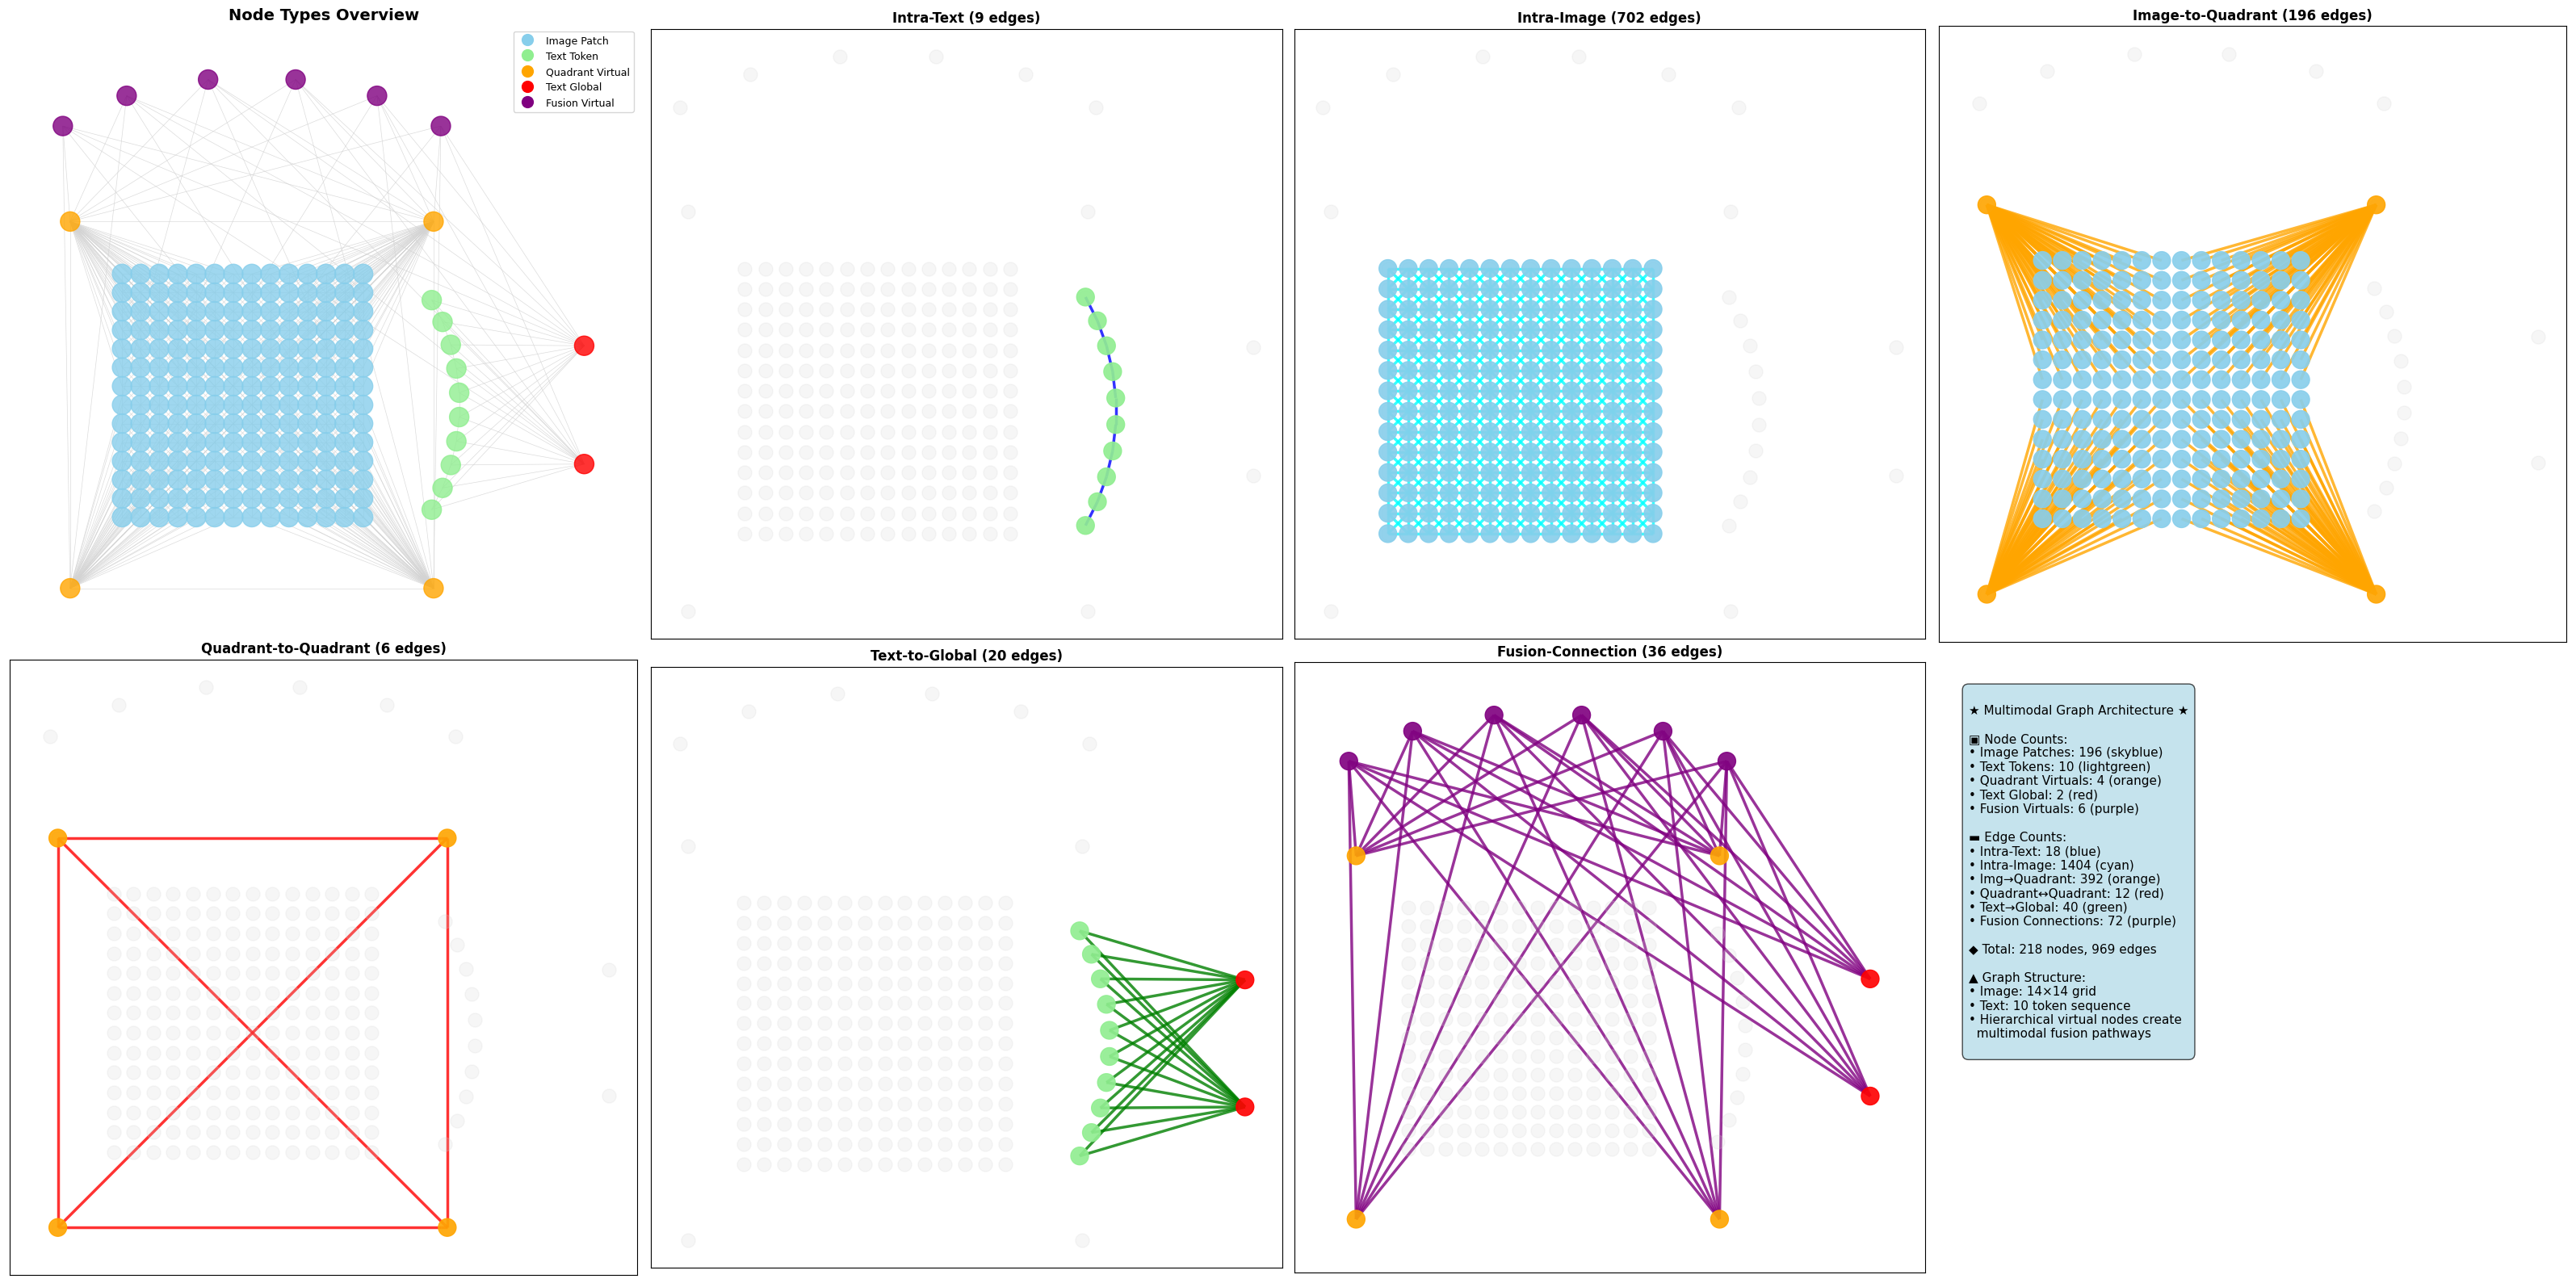

Node type distribution:
  image: 196 nodes
  text: 10 nodes
  quadrant: 4 nodes
  text-global: 2 nodes
  fusion: 6 nodes

Edge type distribution:
  intra-text: 18 edges
  intra-image: 1404 edges
  img-to-quadrant: 392 edges
  quadrant-to-quadrant: 12 edges
  text-to-global: 40 edges
  fusion-connection: 72 edges
Debug: Found 4 quadrant nodes: [205, 206, 207, 208]
Debug: Found 2 text-global nodes: [209, 210]
Debug: Found 6 fusion nodes: [211, 212, 213, 214, 215, 216]


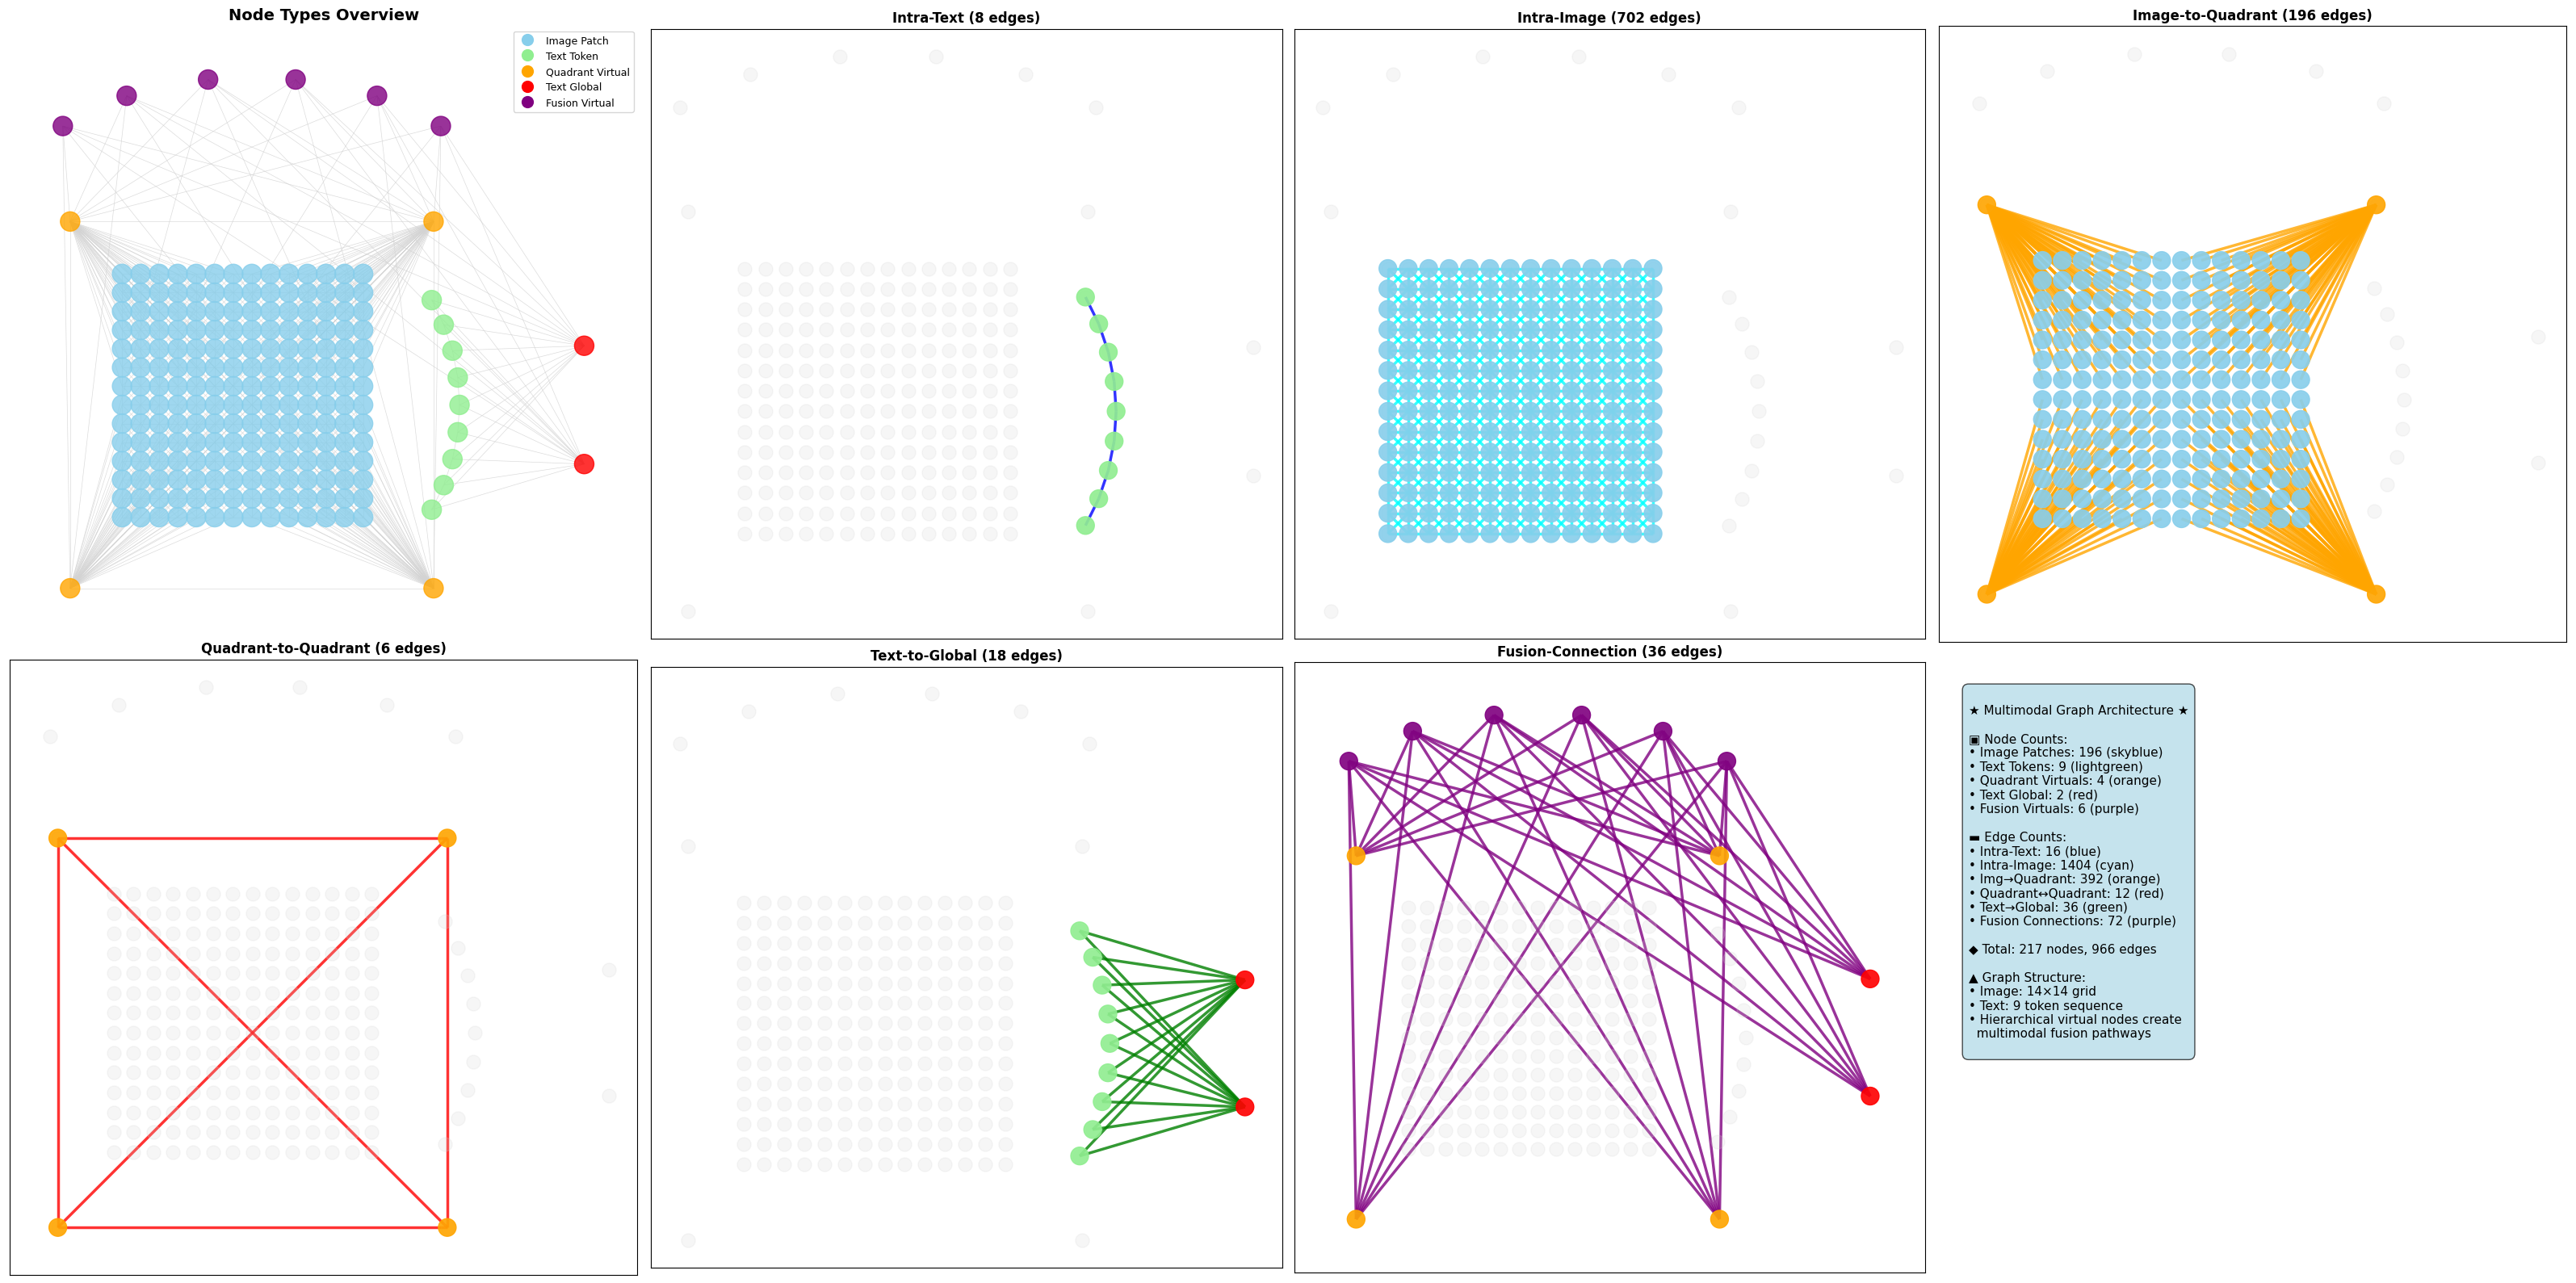

Node type distribution:
  image: 196 nodes
  text: 9 nodes
  quadrant: 4 nodes
  text-global: 2 nodes
  fusion: 6 nodes

Edge type distribution:
  intra-text: 16 edges
  intra-image: 1404 edges
  img-to-quadrant: 392 edges
  quadrant-to-quadrant: 12 edges
  text-to-global: 36 edges
  fusion-connection: 72 edges
Debug: Found 4 quadrant nodes: [199, 200, 201, 202]
Debug: Found 2 text-global nodes: [203, 204]
Debug: Found 6 fusion nodes: [205, 206, 207, 208, 209, 210]


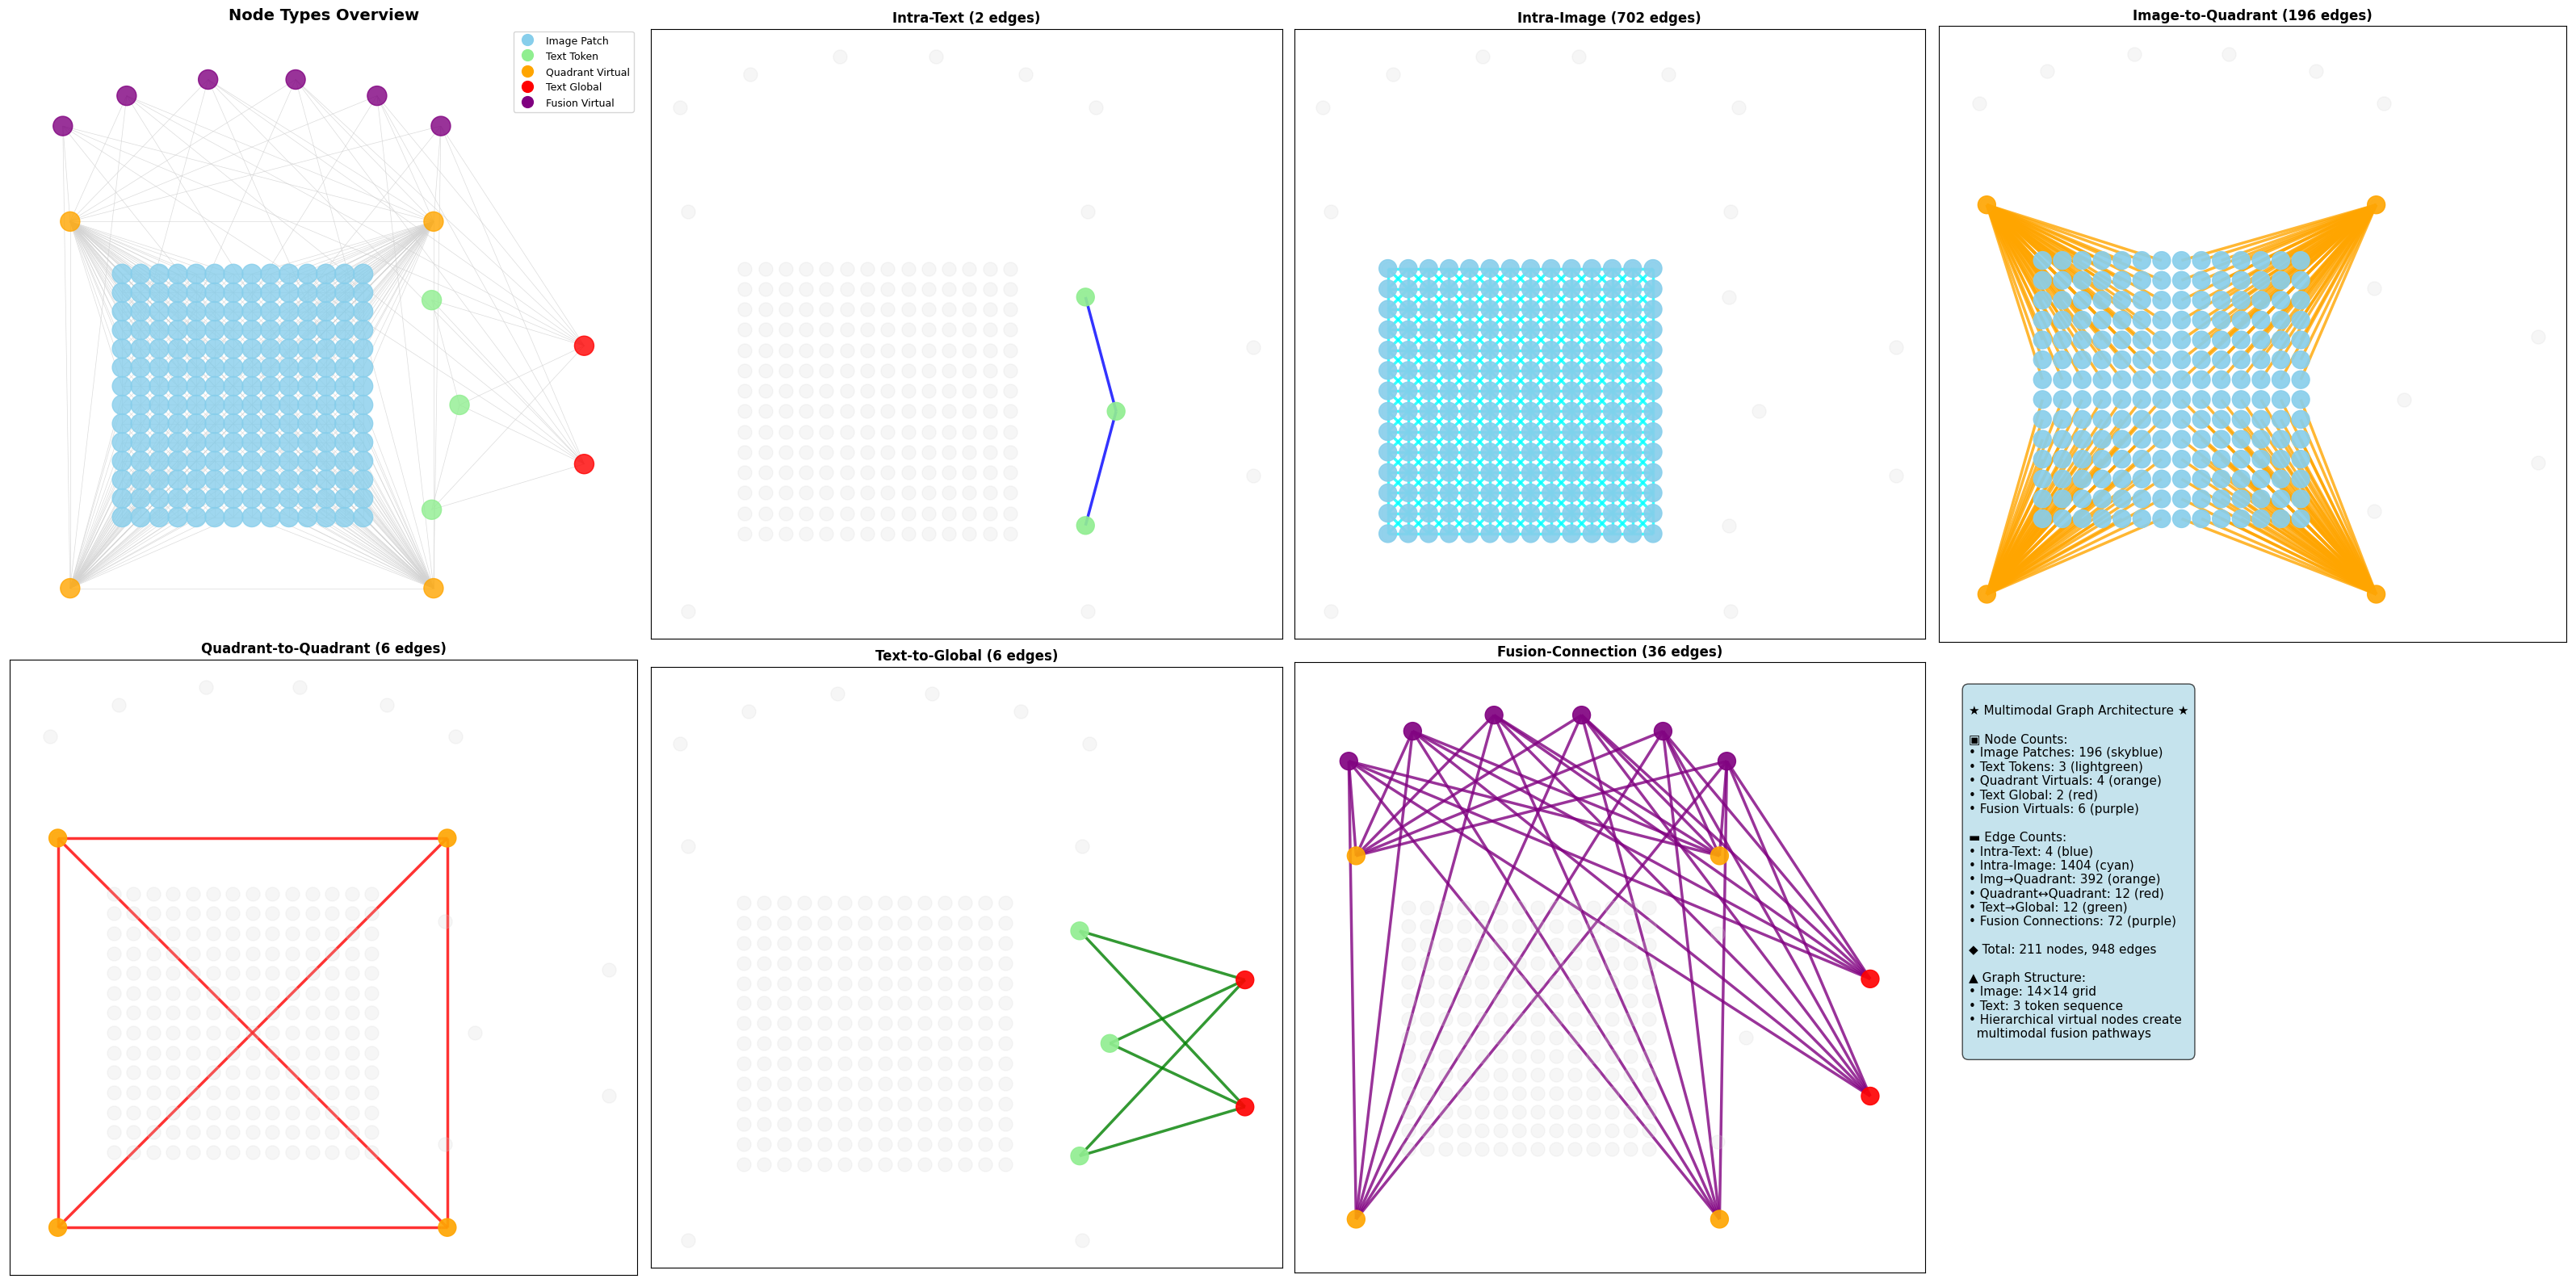

Node type distribution:
  image: 196 nodes
  text: 3 nodes
  quadrant: 4 nodes
  text-global: 2 nodes
  fusion: 6 nodes

Edge type distribution:
  intra-text: 4 edges
  intra-image: 1404 edges
  img-to-quadrant: 392 edges
  quadrant-to-quadrant: 12 edges
  text-to-global: 12 edges
  fusion-connection: 72 edges


In [7]:
for i in range(len(res)):
	visualize_mmg_with_types(res[i], num_img=img_embeds.shape[1], num_text=(text_inputs['attention_mask'][i] == 1).sum().item())